# DBSCAN Debugging

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

agg = pd.read_csv('../data/outputs/agg_features.csv')

The following plot helps choose a good `eps` value by examining the distance to the 4th nearest neighbour.

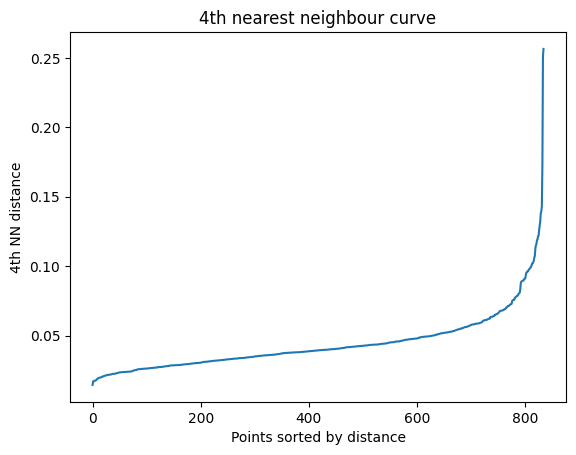

In [22]:
sim_cols = [c for c in agg.columns if c not in {'record_id','cluster'}]
neigh = NearestNeighbors(n_neighbors=4)
neigh.fit(agg[sim_cols])
# Distances to the 4th nearest neighbour for each point
dists, _ = neigh.kneighbors(agg[sim_cols])
fourth = dists[:, -1]
plt.plot(sorted(fourth))
plt.xlabel('Points sorted by distance')
plt.ylabel('4th NN distance')
plt.title('4th nearest neighbour curve')
plt.show()

Use a knee in the curve above to set `eps`.

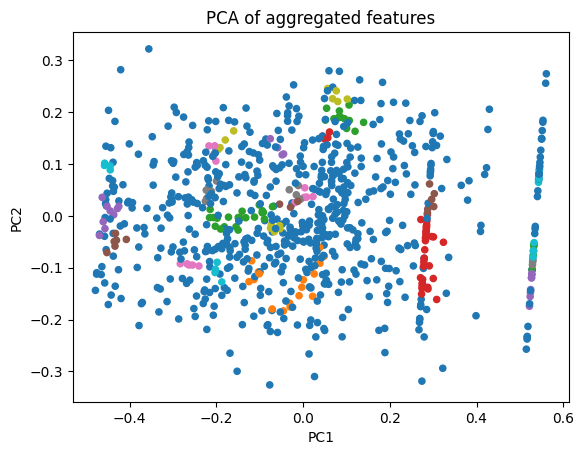

In [23]:
pca = PCA(n_components=2)
X = pca.fit_transform(agg[sim_cols])
plt.figure()
if 'cluster' in agg.columns:
    plt.scatter(X[:,0], X[:,1], c=agg['cluster'], cmap='tab10', s=20)
else:
    plt.scatter(X[:,0], X[:,1], s=20)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of aggregated features')
plt.show()

If cluster labels are provided, the scatter plot is coloured accordingly to inspect separability.

In [24]:
agg['cluster'].value_counts()


cluster
-1     535
 1      90
 6      21
 8      18
 0      16
 9      16
 5      13
 12     10
 4       9
 13      9
 7       6
 21      6
 16      6
 14      6
 2       5
 24      5
 19      5
 18      5
 3       5
 25      5
 10      4
 15      4
 29      4
 27      4
 17      4
 23      4
 11      4
 26      4
 22      4
 20      4
 28      4
Name: count, dtype: int64

Display the number of records in each cluster to identify large or potentially problematic clusters.

In [25]:
big = agg[agg['cluster'] == 0]           # or whichever label is huge
big.head(20)                             # see company/domain/phone fields


,record_id,company_sim,domain_sim,address_sim,phone_exact,cluster
12,f92e75561b0d8294b37020e6b04bcb23,0.587943,0.656758,0.250000,0.0,0
82,b201f12383c6529058f18798beaad341,0.582812,0.639300,0.319697,0.0,0
260,f41092201bcf6850d5d38738dc4bcbd6,0.577786,0.654848,0.220509,0.0,0
326,79348f1b1b365910d1f74119b04bcba0,0.582710,0.666635,0.301820,0.0,0
424,6aba78c41b7380108321311d0d4bcb24,0.640494,0.637002,0.291833,0.0,0
454,9afc839c1b2ad1d01c3ddc6fcc4bcb9c,0.614377,0.653614,0.295041,0.0,0
487,2a58ab361b9dd1141c3ddc6fcc4bcb5c,0.584290,0.644876,0.246527,0.0,0
504,1daafc841b7380108321311d0d4bcb32,0.634643,0.657129,0.298050,0.0,0
521,880f1ef71b58a114d1f74119b04bcba6,0.649057,0.668470,0.317835,0.0,0
529,098afc441b7380108321311d0d4bcb19,0.556540,0.687463,0.250000,0.0,0


Inspect the records in the largest (or a selected) cluster to review company, domain, and phone fields for further analysis or manual investigation.